# Non-Adiabatic Explosion

Code for project 2

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#For checking answers
import scipy.integrate as spi
import scipy.optimize as spo

sns.set()
sns.set_style('whitegrid')
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=15)
lw = 3

In [24]:
def newton(p0, f, df, tolerance=0.01, max_iter=1000, seq=False):
        p = []
        iterations = 1
    
        p.append(p0)
        p_new = p0 - f(p0)/df(p0)
        p.append(p_new)
        
        while np.abs((p_new-p0)/p0) > tolerance and iterations<max_iter:
            iterations += 1
            
            p0 = p_new
            p_new = p0 - f(p0)/df(p0)
            p.append(p_new)
            
        if seq:
            return (p_new, p, iterations)
        
        return p_new
    
def rk4(funcs, t, y0):
    num_funcs = y0.shape[0]
    if num_funcs != len(funcs):
        raise ValueError('Number of functions dont match number of initial conditions!')
    
    h = t[1]-t[0] #Assuming everything is evenly spaced
    K = np.zeros((4, num_funcs)) #K's
    
    #Make a solution array
    y = np.zeros((len(t), num_funcs))
    y[0,:] = y0
                 
    for i in range(len(t)-1):
        #Iterate and evaluate
        #K's
        for j in range(num_funcs):
            K[0,j] = h*funcs[j](t[i], y[i,:])
        for j in range(num_funcs):
            K[1,j] = h*funcs[j](t[i]+(h/2), y[i,:]+(K[0,:]/2))
        for j in range(num_funcs):
            K[2,j] = h*funcs[j](t[i]+(h/2), y[i,:]+(K[1,:]/2))
        for j in range(num_funcs):
            K[3,j] = h*funcs[j](t[i]+h, y[i,:]+K[2,:])

        #Next point
        y[i+1,:] = y[i,:] + (1/6)*(K[0,:]+2*K[1,:]+2*K[2,:]+K[3,:])
                 
    return y

#Legendre polynomial roots (i.e. eval locations)
gqLoc = np.array([-np.sqrt(15)/5, 0, np.sqrt(15)/5])
gqCoeff = np.array([5/9, 8/9, 5/9])

#Gaussian Quadrature integration n=3
def gaussQuad(f, a, b):
    #Need to convert to [-1,1]
    factor = (b-a)/2
    def transform(x):
        return (x*(b-a)+a+b)/2
    
    #Using lookup table
    t = transform(gqLoc)
    c = gqCoeff
    
    I = factor*(np.dot(c,f(t)))
        
    return I

#Simpson's 1/3 integration
def newtonCotes_n5(f, a, b, h=0.1):
    pts = np.arange(a,b+h,h)
    y = f(pts)
    for i in range(1,len(y)-1):
        if i%2==0:
            y[i] *= 2
        else:
            y[i] *= 4
            
    return (h/3)*np.sum(y)

#Integrate with singularity on left 
def leftSingular(f, a, b):
    def func(t):
        y = np.zeros(len(t))
        for i in range(len(t)):
            if t[i]==0:
                y[i]=0
            else:
                y[i]=f(t[i])
                
        return y
        
#     return gaussQuad(func, a, b)
    return simpson_13(func, a, b, h=0.01)

#Integrate with infinite endpoint
#Assuming right endpoint is infinity
def intImproper(f, a, c):
    I1 = 0
    
    #Calculate first bit if need be
    if a==0:
        I1 = gaussQuad(f, a, c)
        a = c
    
    #Transform first 
    a = 1/a
    def func(t):
        return (1/t**2)*f(1/t)
    
    I2 = leftSingular(func, 0, a)
    
    return I1+I2

## Q1

In [25]:
delta = 1/3

def dTdS(sigma, theta):
    return delta*np.exp(theta) - theta

h = 0.01
sigma = np.arange(0, 10+h, h)
ic = np.zeros(1)

theta = rk4([dTdS], sigma, ic)

In [26]:
def thetaFiz(theta):
    return np.exp(theta)/theta-1/delta

def dthetaFiz(theta):
    return (theta*np.exp(theta)-np.exp(theta))/theta**2

def thetaLong(sigma):
    pass

def thetaShort(sigma):
    return (delta/(delta-1))*(np.exp(sigma*(delta-1))-1)

In [27]:
theta_fiz = newton(0.7, thetaFiz, dthetaFiz)

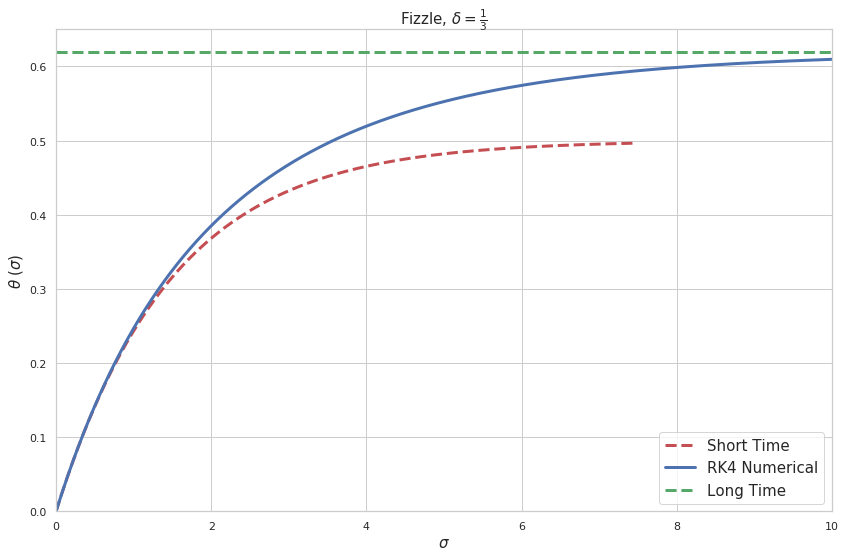

In [38]:
s_short = sigma[:3*int(len(sigma)/4)]

fig_fiz, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(s_short, thetaShort(s_short), lw=lw, c='r', ls='dashed')
ax.hlines(theta_fiz, sigma[0], sigma[-1], lw=lw, ls='dashed', color='g')
ax.plot(sigma, theta, lw=lw, c='b')

ax.set_title(r'Fizzle, $\delta=\frac{1}{3}$')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\theta\;(\sigma)$')
ax.legend(['Short Time', 'RK4 Numerical', 'Long Time'], loc=4)
ax.set_ylim(0, 0.65)
ax.set_xlim(0, 10)

plt.tight_layout()

## Q2

In [10]:
delta = 1

def dSdT(theta, sigma):
    return 1/(delta*np.exp(theta)-theta)

def f(x):
    return 1/(delta*np.exp(x)-x)

h = 0.001
theta2 = np.arange(0, 5+h, h)
ic = np.zeros(1)

In [11]:
sigma2 = rk4([dSdT], theta2, ic) #Solving ODE

sigma_exp = intImproper(f, 0, 3) #Integrating to find sigma explosion
# sigma_exp = gaussQuad(f,0,3)
print(sigma_exp) #Should be 1.35909

1.3599139639416509


In [12]:
def longTime(theta):
    return sigma_exp - 1/(delta*np.exp(theta))

def shortTime(theta):
    return delta*theta

(0, 5)

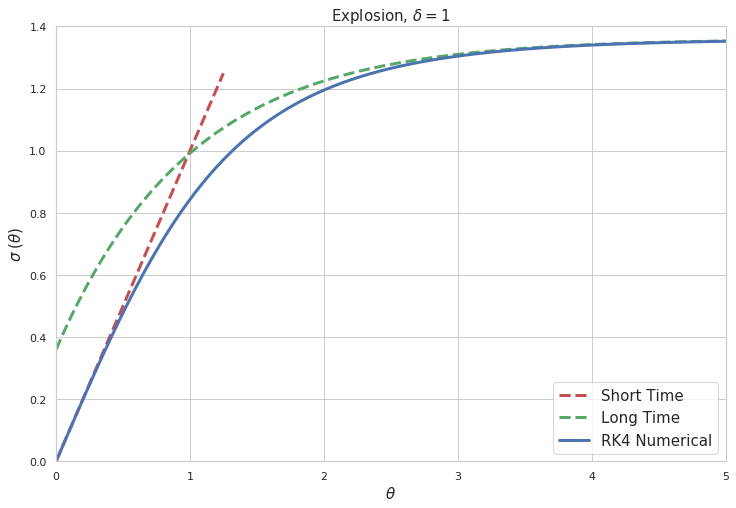

In [21]:
t_short = theta2[:int(len(theta2)/4)]
# t_long = theta2[int(len(theta2)/6):]

fig_exp, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(t_short, shortTime(t_short), c='r', ls='dashed', lw=lw)
ax.plot(theta2, longTime(theta2), c='g', ls='dashed', lw=lw)
ax.plot(theta2, sigma2, c='b', lw=lw)

ax.set_title(r'Explosion, $\delta=1$')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\sigma\;(\theta)$')
ax.legend(['Short Time', 'Long Time', 'RK4 Numerical'])
ax.set_ylim(0, 1.4)
ax.set_xlim(0, 5)
# plt.tight_layout()

## Extra

Plot fizzle and explosion together

(0, 10)

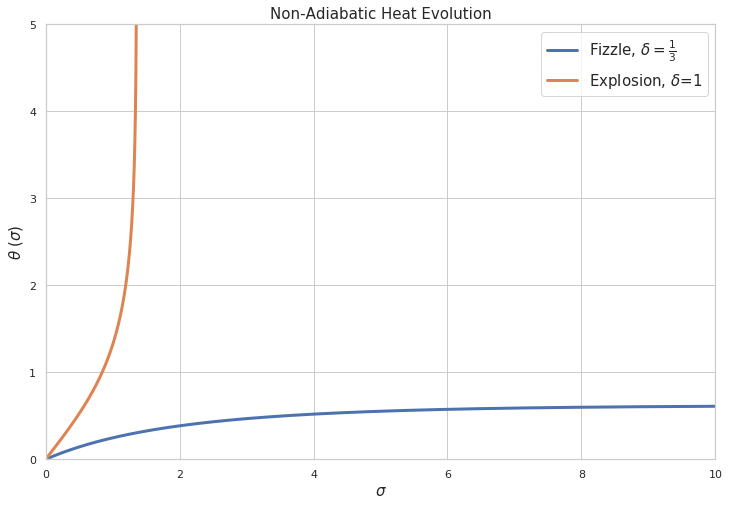

In [20]:
fig_both, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(sigma, theta, lw=lw)
ax.plot(sigma2, theta2, lw=lw)

ax.set_title('Non-Adiabatic Heat Evolution')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\theta\;(\sigma)$')
ax.legend([r'Fizzle, $\delta=\frac{1}{3}$','Explosion, $\delta$=1'])
ax.set_ylim(0,5)
ax.set_xlim(0, 10)
# plt.tight_layout()

In [22]:
fig_exp.savefig('explosion.png')
fig_both.savefig('fizzle-explosion.png')